Author: Bram van Duinen

Date: 14 nov 2023

Content: Trying to load in some demand data, and detecting events with high residual load. Calculating co-occurences of max residual load per run in-between countries

In [208]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap
import colorcet as cc
import seaborn as sns
import itertools

In [220]:
from mappings import df_countries

df_countries

,index_nr,EU_map,nuts_id,entsoe,entsoe_transparency,name
ISO31661A3,,,,,,
ALB,0,ALB,AL,,AL,Albania
AUT,1,AUT,AT,AT,AT,Austria
UKR,2,UKR,,,UA,Ukraine
BIH,3,BIH,BA,BA,BA,Bosnia and Herzegovina
BEL,4,BEL,BE,BE,BE,Belgium
BGR,5,BGR,BG,BG,BG,Bulgaria
CHE,6,CHE,CH,CH,CH,Switzerland
CYP,7,CYP,CY,CY,CY,Cyprus
CZE,8,CZE,CZ,CZ,CZ,Czechia


In [136]:
daily = '/net/pc200256/nobackup/users/most/LENTIS/present/day/'
psl = xr.open_dataset(daily + 'psl_d/psl_d_ECEarth3_h010.nc')
tas = xr.open_dataset(daily + 'tas_d/tas_d_ECEarth3_h010.nc')

energy = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'
NOR = xr.open_dataset(energy + 'NOR_LENTIS_PD_02_v4.nc')
SWE = xr.open_dataset(energy + 'SWE_LENTIS_PD_02_v4.nc')

In [137]:
def add_filename(ds):
    # Extract the filename from the 'source' attribute, which is automatically set by open_mfdataset
    filename = os.path.basename(ds.encoding['source'])
    
    # Extract the characters that match the '???' part of the filename
    identifier = filename.split('_')[0]
    
    # Add the identifier as a new coordinate to the dataset
    ds = ds.assign_coords(country_name=identifier)
    
    return ds

data_prod = xr.open_mfdataset(energy + '???' + '_LENTIS_PD_02_v4.nc', combine='nested', concat_dim='country', preprocess=add_filename)

num_countries = np.shape(data_prod.residual)[0]

In [138]:
data_prod

<xarray.Dataset>
Dimensions:        (time: 3591, country: 24, runs: 160)
Coordinates:
  * time           (time) datetime64[ns] 2000-02-01T12:00:00 ... 2009-11-30T1...
  * runs           (runs) object 'h010' 'h011' 'h012' ... 'h167' 'h168' 'h169'
  * country        (country) float64 1.0 5.0 3.0 6.0 8.0 ... 34.0 37.0 36.0 35.0
    country_name   (country) <U3 'AUT' 'BGR' 'BIH' 'CHE' ... 'SVK' 'SVN' 'SWE'
Data variables: (12/15)
    pv_util        (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
    pv_roof        (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
    wind_offshore  (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
    wind_onshore   (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
    ror            (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
    temp           (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
    ...             ...
    Ein            (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
    inflow         (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
    reservoir      (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
    conventional   (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
    total_RE       (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
    residual       (country, runs, time) float64 dask.array<chunksize=(1, 160, 3591), meta=np.ndarray>
Attributes:
    author:   Lieke van der Most - RUG/KNMI
    project:  ICEVEPS
    area:     EU
    source:   LENTIS 1600 years (parent 01-16 and seed 0-9)
    history:  Computed 14-Nov-2023 (09:24)
    climate:  pd

In [139]:
max_residuals = data_prod.residual.max(dim='time')
times_of_max_residuals = data_prod.residual.time.isel(time=data_prod.residual.argmax(dim='time').compute())

# Combine into a single Dataset
result = xr.Dataset({'max_residual': max_residuals, 'time_of_max_residual': times_of_max_residuals})

In [140]:
NOR_maxres = result.where(result.country_name == 'NOR', drop=True).max_residual.values

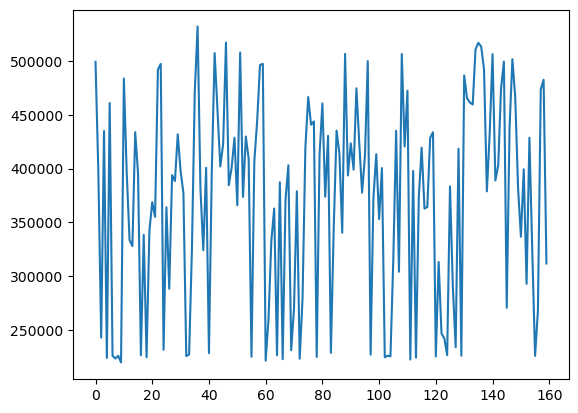

In [141]:
plt.plot(NOR_maxres.squeeze())

/tmp/ipykernel_3343234/753813968.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cc.cm.glasbey_hv)
/tmp/ipykernel_3343234/753813968.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(times_of_max_residuals[i], max_residuals[i], c=discrete_cmap(i), label=countries[i])
/tmp/ipykernel_3343234/753813968.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use

/tmp/ipykernel_3343234/753813968.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(times_of_max_residuals[i], max_residuals[i], c=discrete_cmap(i), label=countries[i])
/tmp/ipykernel_3343234/753813968.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(times_of_max_residuals[i], max_residuals[i], c=discrete_cmap(i), label=countries[i])


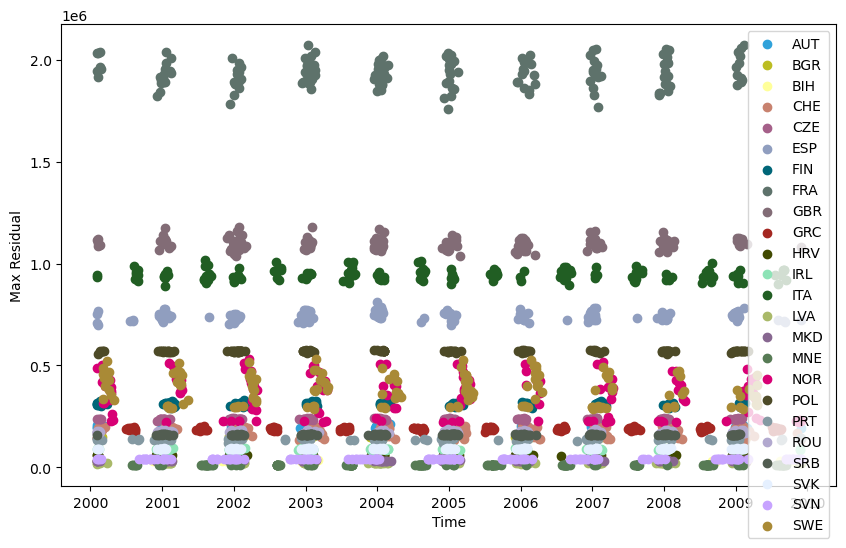

In [142]:
# Create a mapping from country names to numbers
unique_countries = np.unique(countries)
country_to_number = {country: number for number, country in enumerate(unique_countries)}
country_numbers = np.array([country_to_number[country] for country in countries])


# Get a colormap
cmap = plt.cm.get_cmap(cc.cm.glasbey_hv)

# Create a colormap with 30 discrete points
discrete_cmap = ListedColormap(cmap(np.linspace(0, 1, num_countries)))

# Create a scatter plot
plt.figure(figsize=(10, 6))
for i in range(num_countries):
    plt.scatter(times_of_max_residuals[i], max_residuals[i], c=discrete_cmap(i), label=countries[i])
plt.legend()

# Add labels
plt.xlabel('Time')
plt.ylabel('Max Residual')

plt.show()

(array([1564.,  663.,  195.,  101.,    5.,    5.,  137.,  254.,   64.,
          33.,   84.,  735.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <BarContainer object of 12 artists>)

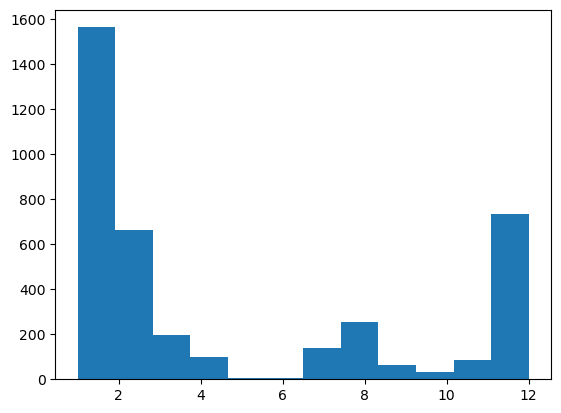

In [157]:
months = times_of_max_residuals.dt.month.values.flatten()
#make a histogram of months
plt.hist(months, bins=12)

In [162]:
# Flatten and sort the array
times_of_max_residuals_flat = np.sort(times_of_max_residuals.values.flatten())

# Calculate the differences between consecutive elements
differences = np.diff(times_of_max_residuals_flat)

# Count the number of differences that are less than or equal to 1 day
co_occurrences = np.sum(differences <= np.timedelta64(1, 'D'))

print(co_occurrences)

3354


In [163]:
# Initialize a DataArray to store the co-occurrences
co_occurrences = xr.DataArray(
    np.zeros_like(times_of_max_residuals, dtype=bool),
    coords=times_of_max_residuals.coords,
    dims=times_of_max_residuals.dims
)

# Iterate over the 'country' and 'runs' dimensions
for country in times_of_max_residuals.country:
    for i in range(len(times_of_max_residuals.runs) - 1):
        # Compare the times of max residuals for each pair of consecutive runs
        difference = times_of_max_residuals.sel(country=country, runs=times_of_max_residuals.runs[i+1]) - times_of_max_residuals.sel(country=country, runs=times_of_max_residuals.runs[i])
        co_occurrences.loc[dict(country=country, runs=times_of_max_residuals.runs[i+1])] = abs(difference) <= np.timedelta64(1, 'D')

print(co_occurrences)

<xarray.DataArray (country: 24, runs: 160)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time          (country, runs) datetime64[ns] 2002-01-23T12:00:00 ... 2005...
  * runs          (runs) object 'h010' 'h011' 'h012' ... 'h167' 'h168' 'h169'
  * country       (country) float64 1.0 5.0 3.0 6.0 8.0 ... 34.0 37.0 36.0 35.0
    country_name  (country) <U3 'AUT' 'BGR' 'BIH' 'CHE' ... 'SVK' 'SVN' 'SWE'


In [166]:
times_of_max_residuals.runs

<xarray.DataArray 'runs' (runs: 160)>
array(['h010', 'h011', 'h012', 'h013', 'h014', 'h015', 'h016', 'h017', 'h018',
       'h019', 'h020', 'h021', 'h022', 'h023', 'h024', 'h025', 'h026', 'h027',
       'h028', 'h029', 'h030', 'h031', 'h032', 'h033', 'h034', 'h035', 'h036',
       'h037', 'h038', 'h039', 'h040', 'h041', 'h042', 'h043', 'h044', 'h045',
       'h046', 'h047', 'h048', 'h049', 'h050', 'h051', 'h052', 'h053', 'h054',
       'h055', 'h056', 'h057', 'h058', 'h059', 'h060', 'h061', 'h062', 'h063',
       'h064', 'h065', 'h066', 'h067', 'h068', 'h069', 'h070', 'h071', 'h072',
       'h073', 'h074', 'h075', 'h076', 'h077', 'h078', 'h079', 'h080', 'h081',
       'h082', 'h083', 'h084', 'h085', 'h086', 'h087', 'h088', 'h089', 'h090',
       'h091', 'h092', 'h093', 'h094', 'h095', 'h096', 'h097', 'h098', 'h099',
       'h100', 'h101', 'h102', 'h103', 'h104', 'h105', 'h106', 'h107', 'h108',
       'h109', 'h110', 'h111', 'h112', 'h113', 'h114', 'h115', 'h116', 'h117',
       'h118', 'h119', 'h120', 'h121', 'h122', 'h123', 'h124', 'h125', 'h126',
       'h127', 'h128', 'h129', 'h130', 'h131', 'h132', 'h133', 'h134', 'h135',
       'h136', 'h137', 'h138', 'h139', 'h140', 'h141', 'h142', 'h143', 'h144',
       'h145', 'h146', 'h147', 'h148', 'h149', 'h150', 'h151', 'h152', 'h153',
       'h154', 'h155', 'h156', 'h157', 'h158', 'h159', 'h160', 'h161', 'h162',
       'h163', 'h164', 'h165', 'h166', 'h167', 'h168', 'h169'], dtype=object)
Coordinates:
  * runs     (runs) object 'h010' 'h011' 'h012' 'h013' ... 'h167' 'h168' 'h169'
Attributes:
    standard_name:      LENTIS run
    long_name:          LENTIS run scenario climate
    naming_convention:  h(parent-02d)(seed-01d)

In [221]:
# Initialize a DataArray to store the co-occurrences
co_occurrences = xr.DataArray(
    np.zeros((len(times_of_max_residuals.runs), len(times_of_max_residuals.country), len(times_of_max_residuals.country)), dtype=bool),
    coords={'runs': times_of_max_residuals.runs, 'country_1': times_of_max_residuals.country.values, 'country_2': times_of_max_residuals.country.values},
    dims=['runs', 'country_1', 'country_2']
)

# Iterate over the 'runs' dimension
for run in times_of_max_residuals.runs:
    print(run)
    # Compare the times of max residuals for each pair of countries
    for country_1, country_2 in itertools.product(times_of_max_residuals.country, repeat=2):
        #print(country_1)
        difference = times_of_max_residuals.sel(runs=run, country=country_1) - times_of_max_residuals.sel(runs=run, country=country_2)
        co_occurrences.loc[dict(runs=run, country_1=country_1.values, country_2=country_2.values)] = abs(difference) <= np.timedelta64(3, 'D')

<xarray.DataArray 'runs' ()>
array('h010', dtype='<U4')
Coordinates:
    runs     <U4 'h010'
Attributes:
    standard_name:      LENTIS run
    long_name:          LENTIS run scenario climate
    naming_convention:  h(parent-02d)(seed-01d)
<xarray.DataArray 'runs' ()>
array('h011', dtype='<U4')
Coordinates:
    runs     <U4 'h011'
Attributes:
    standard_name:      LENTIS run
    long_name:          LENTIS run scenario climate
    naming_convention:  h(parent-02d)(seed-01d)
<xarray.DataArray 'runs' ()>
array('h012', dtype='<U4')
Coordinates:
    runs     <U4 'h012'
Attributes:
    standard_name:      LENTIS run
    long_name:          LENTIS run scenario climate
    naming_convention:  h(parent-02d)(seed-01d)
<xarray.DataArray 'runs' ()>
array('h013', dtype='<U4')
Coordinates:
    runs     <U4 'h013'
Attributes:
    standard_name:      LENTIS run
    long_name:          LENTIS run scenario climate
    naming_convention:  h(parent-02d)(seed-01d)
<xarray.DataArray 'runs' ()>
array('h014

In [199]:
np.shape(co_occurrences_sum)

(24, 24)

In [222]:
# Sum up the co-occurrences over all runs
co_occurrences_sum = co_occurrences.sum(dim='runs').astype(float)
np.fill_diagonal(co_occurrences_sum.values, np.nan)

# Convert the DataArray to a DataFrame
co_occurrences_df = co_occurrences_sum.to_dataframe(name='co_occurrences').reset_index()

# Create a pivot table
pivot_table = co_occurrences_df.pivot(index='country_1', columns='country_2', values='co_occurrences')

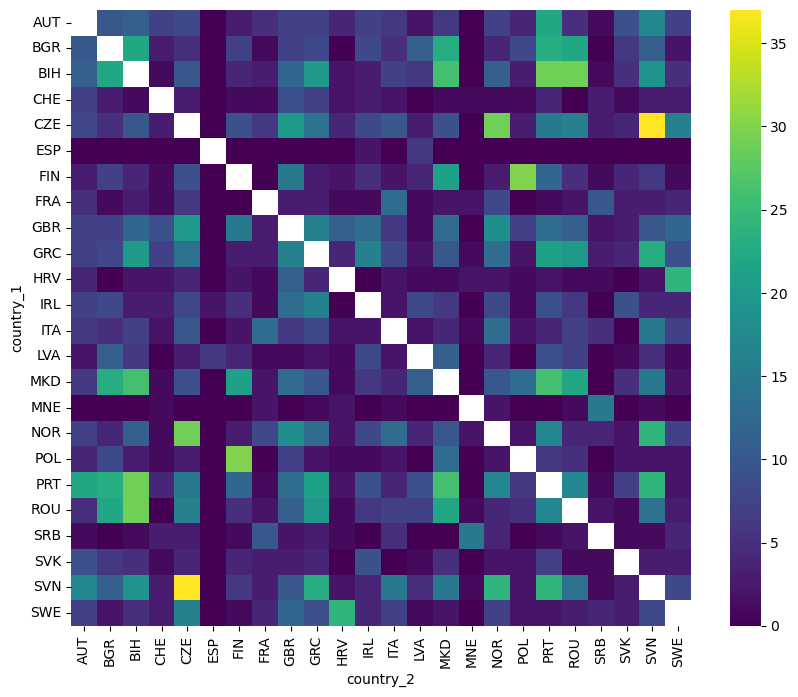

In [223]:
plt.figure(figsize=(10, 8))

sns.heatmap(pivot_table, cmap='viridis')
# Now make the xticks the country identifiers from country_name
plt.xticks(np.arange(num_countries) + 0.5, unique_countries, rotation=90)
plt.yticks(np.arange(num_countries) + 0.5, unique_countries, rotation=0)
plt.show()